# Proyecto 03 - Sistemas de Recomendación

***Presentado por:*** *Sandra Marcela Balbin Agudelo*
***Grupo:*** *DS-ONLINE-38*

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

pd.set_option('display.width', 150)

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Carga Dataset - Reviews**

In [164]:
contador = 0
data_reviews = []
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [165]:
data_reviews = pd.DataFrame(data_reviews)

In [166]:
data_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [167]:
data_reviews.shape

(779307, 12)

In [168]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

**Carga Dataset - Games**

In [169]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [170]:
data_games.head(5)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [171]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


**Elección de variables a usar**

***Dataset Reviews***

* En el Dataset Reviews se dejaron variables que aporten información sobre los usuarios y los juegos, pero que además sean interpretables por el modelo. De esta manera se eliminan las columnas *page_order, date, early_acces, page, compensation* ya que son informativas, la variable *found funny* está en un 85% vacía por lo cual también se retira del dataset. Por último, la variable *user_id* tiene 60% de valores faltantes, por esta razón se elimina y se crea un nuevo **id** para identificar los usuarios.

In [172]:
data_reviews.drop(['page_order','date','early_access','page','found_funny','compensation','user_id','products','text'],
                  axis=1, inplace=True)

* Los registros que no cuentan con horas de juego, no son útiles para desarrollar este sistema de recomendación, por lo tanto se procede a eliminarlos. Estos representan un 0.3% del dataset.

In [173]:
data_reviews.isna().sum()

username         0
hours         2637
product_id       0
dtype: int64

In [174]:
data_reviews.dropna(subset=['hours'], inplace=True)

In [175]:
data_reviews = data_reviews.reset_index(drop = True)
data_reviews.shape

(776670, 3)

***Dataset Games***

* Se eliminan registros que contengan usuario y juego duplicado, aún si las otras características son diferentes ya que puede deberse a que registraron el usuario jugando el mismo juego pero en momentos diferentes. Para esto tomaremos el registro que contenga la mayor cantidad de horas de juego.

In [176]:
max_horas = data_reviews.groupby(['username', 'product_id']).hours.transform(max)
data_reviews = data_reviews[data_reviews.hours == max_horas]

In [177]:
data_reviews.drop_duplicates(subset=['username','product_id'], inplace=True)

* No se toman los registros que no tengan información en el Dataset Reviews.

In [178]:
games_reviews = list(np.unique(data_reviews.product_id))

In [179]:
data_games = data_games[data_games.id.isin(games_reviews)]

* Las variables *app_name, url, release_date, discount_price, reviews_url, early_access, metascore, tags y specs* no representan información relevante para la identificación o comparación de juegos, por lo que no se toman. Además la variable *publisher* tiene la misma información de la variable *developer*, por lo cual no se tiene en cuenta.

In [180]:
data_games.drop(['app_name','url','release_date','discount_price','reviews_url','early_access','metascore',
                 'publisher','sentiment','tags','specs'], axis=1, inplace=True)

In [181]:
data_games = data_games.reset_index(drop = True)
data_games.shape

(12621, 5)

### Parte A - Exploración de Datos

* **Dataset Reviews**

***Variable 'product_id'***

In [182]:
print('Número de juegos existentes')
print(len(np.unique(data_reviews.product_id)))

Número de juegos existentes
12620


In [183]:
games = data_reviews.product_id.value_counts()
print('Número de jugadores por id de juego\n')
print(games)

Número de jugadores por id de juego

440       17409
252490     9708
49520      7007
377160     6817
271590     5745
          ...  
726520        1
358220        1
447240        1
542210        1
754540        1
Name: product_id, Length: 12620, dtype: int64


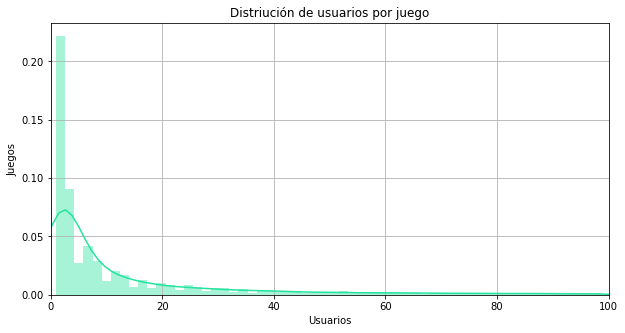

In [184]:
plt.figure(figsize = (10,5))
max_user = 100
plt.title("Distriución de usuarios por juego")
sns.distplot(games[games < max_user], bins = 60, color='#23E39E')
plt.xlabel("Usuarios")
plt.ylabel("Juegos")
plt.xlim(0,max_user)
plt.grid()
plt.show()

In [185]:
print('Número de juegos con al menos 30 jugadores')
print(len(games.index[games.values >= 30]))

Número de juegos con al menos 30 jugadores
2748


In [186]:
suma1 = np.sum(data_reviews.product_id.value_counts().values[games.values >= 30])
print(f'Los juegos arriba mencionados hacen referencia a {suma1} reviews')

Los juegos arriba mencionados hacen referencia a 704726 reviews


**Análisis:** Del total de juegos, solo el 22% tienen más de 30 jugadores. Y de esos juegos se obtienen el 92% de los reviews disponibles.

***Variable 'username'***

In [187]:
print('Número de usuarios existentes')
print(len(np.unique(data_reviews.username)))

Número de usuarios existentes
539035


In [188]:
game_users = data_reviews.username.value_counts()
print('Número de juegos por usuario\n')
print(game_users)

Número de juegos por usuario

Alex                  161
Chris                 137
Nick                  131
Matt                  119
Saint Aaron           114
                     ... 
The Lucky Survivor      1
shadowreaf              1
Haku Yamata             1
Glike™                  1
guicedreaming2002       1
Name: username, Length: 539035, dtype: int64


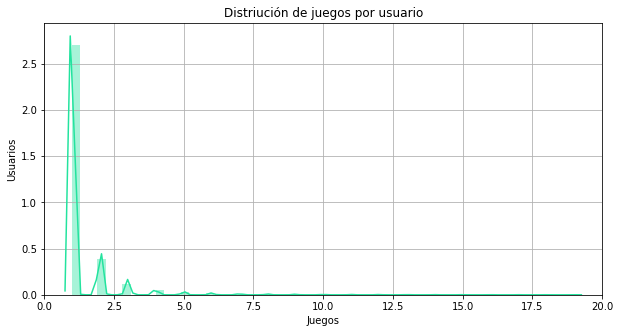

In [189]:
plt.figure(figsize = (10,5))
max_user = 20
plt.title("Distriución de juegos por usuario")
sns.distplot(game_users[game_users< max_user], bins = 60, color='#23E39E')
plt.xlabel("Juegos")
plt.ylabel("Usuarios")
plt.xlim(0,max_user)
plt.grid()
plt.show()

In [190]:
print('Número de usuarios con al menos 5 juegos')
print(len(game_users.index[game_users.values >= 5]))

Número de usuarios con al menos 5 juegos
12783


In [191]:
suma2 = np.sum(data_reviews.username.value_counts().values[game_users.values >= 5])
print(f'Los usuarios arriba mencionados hacen referencia a {suma2} reviews')

Los usuarios arriba mencionados hacen referencia a 115571 reviews


**Análisis:** Solo el 2% de los usuarios juegan más de 5 juegos y estos usuarios aportan el 15% de los reviews.

***Variable 'hours'***

In [192]:
print('promedio : %0.2f' % (data_reviews.hours.mean()))
print('std :      %0.2f' % (data_reviews.hours.std()))
print('mínimo :   %0.2f' % (data_reviews.hours.min()))
print('Q1 :       %0.2f' % (data_reviews.hours.quantile(0.25)))
print('mediana :  %0.2f' % (data_reviews.hours.quantile(0.5)))
print('Q3 :       %0.2f' % (data_reviews.hours.quantile(0.75)))
print('máximo :   %0.2f' % (data_reviews.hours.max()))

promedio : 110.43
std :      387.64
mínimo :   0.00
Q1 :       3.90
mediana :  15.10
Q3 :       58.60
máximo :   28164.00


In [193]:
print('número de entradas con al menos 5 horas de juego')
print(len(data_reviews[data_reviews.hours >= 5]))

número de entradas con al menos 5 horas de juego
547117


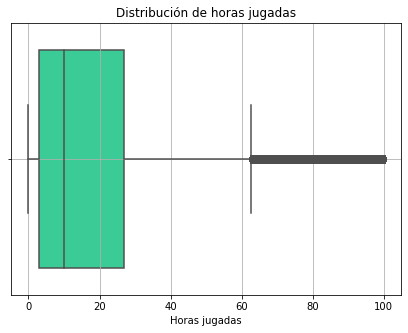

In [194]:
plt.figure(figsize = (7,5))
max_hour = 300
sns.boxplot(x = data_reviews.hours[data_reviews.hours<max_hour/3], color='#23E39E')
plt.title("Distribución de horas jugadas")
plt.xlabel("Horas jugadas")
plt.grid()
plt.show()

**Análisis**: Se evidencia que la mitad de los usuarios tienen 15 horas de juego, y que del total de usuarios el 71% cuenta con más de 5 horas de juego.

* **Dataset Games**

***Variable 'developer'***

In [195]:
print('Número de desarrolladores')
print(len(list(data_games.developer.value_counts().index)))

Número de desarrolladores
8129


In [196]:
developers = data_games.developer.value_counts()
print('Número de juegos por desarrollador\n')
print(developers)

Número de juegos por desarrollador

Choice of Games            48
Humongous Entertainment    34
Telltale Games             32
EnsenaSoft                 29
MumboJumbo                 28
                           ..
Achebit                     1
The Game Bakery             1
alexnown,Kunio              1
Westwood Studios            1
Cargo Cult Gaming LLC       1
Name: developer, Length: 8129, dtype: int64


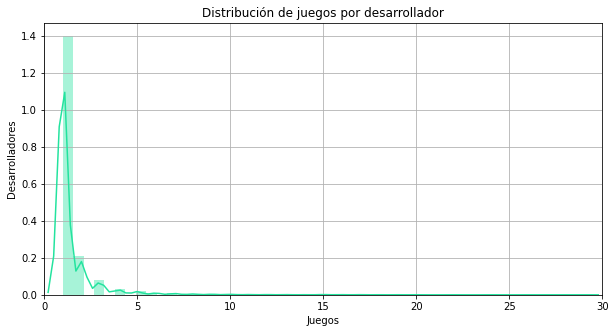

In [197]:
plt.figure(figsize = (10,5))
max_user = 30
plt.title("Distribución de juegos por desarrollador")
sns.distplot(developers[developers < max_user],color='#23E39E')
plt.xlabel("Juegos")
plt.ylabel("Desarrolladores")
plt.xlim(0,max_user)
plt.grid()
plt.show()

In [198]:
print('Número de desarrolladores con más de 1 juego')
print(len(developers.index[developers.values > 1]))

Número de desarrolladores con más de 1 juego
1755


**Análisis:** La mayoría de los desarrolladores solo tienen un juego en la plataforma, solo el 22% tienen más de uno.

***Variable 'genre'***

In [199]:
generos = []
for lista in data_games.genres:
    if type(lista) == list:
        generos.append(lista)

In [200]:
generos = [item 
           for sublist in generos
           for item in sublist]

In [201]:
index_generos = list(np.unique(generos))
values_generos = [generos.count(item) for item in index_generos]

genres_dist = pd.Series(values_generos, index = index_generos) 

In [202]:
print('Distribución de los generos por número de juegos:\n')
print(genres_dist.sort_values(ascending=False))

Distribución de los generos por número de juegos:

Indie                        8175
Action                       5495
Adventure                    4407
Casual                       3677
Strategy                     2743
RPG                          2200
Simulation                   2038
Early Access                 1056
Free to Play                  835
Sports                        488
Racing                        467
Massively Multiplayer         405
Utilities                     116
Design &amp; Illustration      87
Animation &amp; Modeling       66
Video Production               41
Education                      35
Software Training              30
Audio Production               30
Web Publishing                 26
Photo Editing                  21
dtype: int64


**Análisis:** El 80% de los juegos se ubican en los primeros 6 géneros, donde Indie tiene el 25% y Action el 17%.

***Variable 'price'***

In [203]:
price = []
for element in data_games.price:
    if type(element) == str:
        element = element.lower()
    price.append(element)

data_games['price'] = price

In [204]:
print('Número de juegos free to play: ')
print(len(data_games[data_games.price == 'free to play']))

Número de juegos free to play: 
700


In [205]:
print('Número de juegos sin información del precio: ')
print(data_games.price.isna().sum())

Número de juegos sin información del precio: 
146


In [206]:
data_games_1 = data_games[pd.to_numeric(data_games.price, errors='coerce').notnull()]

In [207]:
print('promedio : %0.2f' % (data_games_1.price.mean()))
print('std :      %0.2f' % (data_games_1.price.std()))
print('mínimo :   %0.2f' % (data_games_1.price.min()))
print('Q1 :       %0.2f' % (data_games_1.price.quantile(0.25)))
print('mediana :  %0.2f' % (data_games_1.price.quantile(0.5)))
print('Q3 :       %0.2f' % (data_games_1.price.quantile(0.75)))
print('máximo :   %0.2f' % (data_games_1.price.max()))

promedio : 10.40
std :      14.15
mínimo :   0.49
Q1 :       3.99
mediana :  7.99
Q3 :       12.99
máximo :   771.71


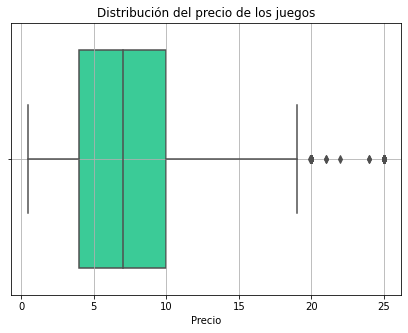

In [208]:
plt.figure(figsize = (7,5))
max_price = 100
sns.boxplot(x = data_games_1.price[data_games_1.price<max_price/4], color='#23E39E')
plt.title("Distribución del precio de los juegos")
plt.xlabel("Precio")
plt.grid()
plt.show()

In [209]:
print('El juego más costoso es:\n')
print(list(data_games_1.sort_values(by=['price','title'], ascending=False).title.values)[:1])

El juego más costoso es:

['X-Plane 10 Global - 64 Bit']


In [210]:
print('El juego más económico es:\n')
print(list(data_games_1.sort_values(by=['price','title'], ascending=True).title.values)[:1])

El juego más económico es:

['Fate Tectonics']


**Análisis:** La mitad de los juegos tienen un precio al rededor de los 8 USD, el juego más costoso vale 771 USD.

### Parte B - Modelo de Machine Learning

* **Preprocesamiento de los datos** 

***Generación de una calificación***

El Dataset Reviews no cuenta con una calificación explícita de los juegos y para crear un sistema de recomendación deben existir calificaciones. Se asume que si un jugador juega más de 5 horas un juego es porque le gusta, bajo este supuesto se crea una calificación binaria en la variable *'ratings'* donde si es inferior a 5 horas obtiene 'dislike' y si es igual o mayor a 5 horas 'like'.

In [211]:
def ratings(time):
    if time >= 5:
        return 1
    else:
        return 0

In [212]:
ratings = data_reviews['hours'].apply(ratings)

data_reviews['ratings'] = ratings

In [213]:
data_reviews.head(5)

,username,hours,product_id,ratings
0,Chaos Syren,0.1,725280,0
1,Ariman1,13.2,328100,1
2,freakfantom,0.1,725280,0
3,The_Cpt_FROGGY,7.8,631920,1
4,the_maker988,8.2,35140,1


In [214]:
data_reviews = data_reviews[data_reviews.ratings == 1]

In [215]:
data_reviews = data_reviews.reset_index(drop = True)
data_reviews.shape

(547117, 4)

***Eliminación de juegos poco populares***

Se eliminan los juegos que tienen menos de 25 jugadores, pues no son lo suficientemente populares para desarrollar un sistema de recomendación.

In [216]:
lista = list(data_reviews.product_id.value_counts().index[data_reviews.product_id.value_counts().values >= 25])

In [217]:
data_reviews = data_reviews[data_reviews.product_id.isin(lista)]

In [218]:
data_reviews = data_reviews.reset_index(drop = True)
data_reviews.shape

(512772, 4)

***Eliminación de jugadores con pocos juegos***

Se eliminan los usuarios con menos de 5 juegos, ya que tienen pocos juegos y puede afectar la eficiencia del modelo para recomendar.

In [219]:
lista_users = list(data_reviews.username.value_counts().index[data_reviews.username.value_counts().values >= 5])

In [220]:
data_reviews = data_reviews[data_reviews.username.isin(lista_users)]

In [221]:
data_reviews = data_reviews.reset_index(drop = True)
data_reviews.shape

(45853, 4)

***Generación de un número de identificación de usuarios***

In [222]:
user_names = list(np.unique(data_reviews.username))

In [223]:
user_encoded = np.arange(0,len(user_names))

In [224]:
data_reviews['user_id'] = data_reviews.username.map(dict(zip(user_names,user_encoded)))

***Generación de un número de identificación de juegos***

In [225]:
games = list(np.unique(data_reviews.product_id))

In [226]:
game_encoded = np.arange(0,len(games))

In [227]:
data_reviews['game_id'] = data_reviews.product_id.map(dict(zip(games,game_encoded)))

In [228]:
data_games = data_games[data_games.id.isin(games)]
data_games = data_games.reset_index(drop = True)

In [229]:
data_games['game_id'] = data_games.id.map(dict(zip(games,game_encoded)))

In [230]:
data_reviews.head(5)

,username,hours,product_id,ratings,user_id,game_id
0,Cross,9.3,35140,1,917,1205
1,SuchDoge,14.3,35140,1,4027,1205
2,Raptor,125.0,350280,1,3375,1201
3,Emperor Palpatine,40.7,271590,1,1325,779
4,ThePCGamer,5.3,275180,1,4221,800


* **Elección y desarrollo del modelo**

***Elección del modelo***

La estructura de los datos corresponde un registro de calificaciones dadas por varios jugadores a unos juegos específicos. En este sentido, el modelo de recomendación debe basarse en estas "experiencias" para encontrar similitud entre los jugadores agrupando usuarios por gustos similares, por lo tanto, el modelo que responde a esta necesidad es el **"Filtro Colaborativo"**.
Para esto se usará el modelo de mínimos cuadrado alternantes de la librería implicit.

Importando librerías y generando el dataset para trabajar:

In [231]:
import os
from scipy import sparse
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import train_test_split, ranking_metrics_at_k
os.environ['MKL_NUM_THREADS'] = '1'

In [232]:
data = data_reviews[['game_id','user_id','ratings']]

***Elección de la métrica de evaluación***

Para evaluar el desempeño del modelo se usará la **precisión media promedio a  𝐾  items  (𝑀𝐴𝑃@𝐾)**. Es una métrica muy apropiada para datasets binarios como este, pues permite introducir relevancia a las recomendaciones, dándole más peso a los errores que ocurren más arriba en la lista de recomendaciones.

***Modelo de mínimos cuadrados alternantes***

A partir del dataset Reviews generamos una matriz de utilidad, que tomará los valores de calificación de un usuario por un juego (1 o 0) y los albergará en una matriz con dimensiones (# juegos, # usuarios). Esta matriz está en formato CSR (compressed sparse row matrix). A partir de ella se genera otra matriz con dimensiones (# usuarios, # juegos) que es la transpuesta de la primera matriz.

La primera matriz será usada para entrenar el modelo y la segunda matriz será usada para generar las recomendaciones a partir del modelo entrenado.

In [233]:
matrix_item_user = sparse.csr_matrix((data['ratings'].astype(int), (data['game_id'], data['user_id'])))

In [234]:
matrix_user_item = matrix_item_user.transpose()

In [235]:
matrix_item_user.shape

(1974, 5404)

* *Se ajusta el parámetro inicial*

In [347]:
alpha = 20

* *Se realiza train/test split sobre la matriz user*

In [348]:
train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)

In [349]:
model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=15, random_state=42)

In [350]:
model.fit(train, show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

* *Se realiza validación cruzada para evaluar el modelo mediante la métrica elegida*

In [351]:
p_K = ranking_metrics_at_k(model, train.T, test.T,K=20, num_threads=0,show_progress=True)
print('El modelo tiene un valor de MAP@k igual a : %0.3f' % (p_K['map']))

  0%|          | 0/5404 [00:00<?, ?it/s]

El modelo tiene un valor de MAP@k igual a : 0.021


***Modelo Benchmark***

Se crea un modelo benchmark tomando un top N de los juegos más populares, para eso se desarrolla una clase que permita usar el método para el cálculo de la métrica que contiene la librería implicit.

In [352]:
rango = data.game_id.value_counts().index
puntaje = np.linspace(1.9,-20,len(rango))
recomendacion= list(tuple(zip(rango, puntaje)))

In [353]:
class Benchmark_p:
    
    def __init__(self, recomendacion):
        self.recomendacion = recomendacion
        
    def recommend(self, userid, user_item, N):
        recomendacion =  self.recomendacion[:N]
        return  recomendacion

In [354]:
Benchmark = Benchmark_p(recomendacion)

In [355]:
p_K_benchmark_1 = ranking_metrics_at_k(Benchmark, train.T.tocsr(), test.T.tocsr(), K=20, show_progress=True)
print('el modelo benchmark tiene un valor de MAP@k igual a : %0.3f' % (p_K_benchmark['map']))

  0%|          | 0/5404 [00:00<?, ?it/s]

el modelo benchmark tiene un valor de MAP@k igual a : 0.046


***Optimización de hiperparámetros***

Los principales hiperparámetros de este modelo son el parámetro  𝛼 , el número de factores lantentes, la tasa de regularización  𝜆  y el número de iteraciones. Se prueba la variación de cada hiperparámetro.

* *Alpha*

In [277]:
alphas = [x for x in range(10,61,2)]
metrics_alphas = []

for alpha in alphas:
    train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
    model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=15, random_state=42)
    model.fit(train, show_progress=False)
    r = ranking_metrics_at_k(model, train.T, test.T, K=20, num_threads=0, show_progress=False)
    metrics_alphas.append(r)

* *Factor latente*

In [278]:
factors = [x for x in range(10,61,2)]
metrics_factors = []

for factor in factors:
    alpha = 40
    train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
    model = AlternatingLeastSquares(factors=factor, regularization=0.1, iterations=15, random_state=42)
    model.fit(train, show_progress=False)
    r = ranking_metrics_at_k(model, train.T, test.T, K=20, num_threads=0, show_progress=False)
    metrics_factors.append(r)

* *Tasa de regularización*

In [279]:
regs = [x for x in range(20,71,2)]
metrics_regs = []

for reg in regs:
    alpha = 40
    train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
    model = AlternatingLeastSquares(factors=20, regularization=reg, iterations=15, random_state=42)
    model.fit(train, show_progress=False)
    r = ranking_metrics_at_k(model, train.T, test.T, K=20, num_threads=0, show_progress=False)
    metrics_regs.append(r)

* *Número de iteraciones*

In [280]:
iterations = [x for x in range(15,101,5)]
metrics_iterations = []

for iteration in iterations:
    alpha = 40
    train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
    model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=iteration, random_state=42)
    model.fit(train, show_progress=False)
    r = ranking_metrics_at_k(model, train.T, test.T, K=20, num_threads=0, show_progress=False)
    metrics_iterations.append(r)

In [281]:
map_alpha = []
map_factor = []
map_reg = []
map_iteration = []

for i in range(len(metrics_alphas)):
    map_alpha.append(metrics_alphas[i]['map'])
    
for i in range(len(metrics_factors)):
    map_factor.append(metrics_factors[i]['map'])
    
for i in range(len(metrics_regs)):
    map_reg.append(metrics_regs[i]['map'])
    
for i in range(len(metrics_iterations)):
    map_iteration.append(metrics_iterations[i]['map'])

* *Gráficando*

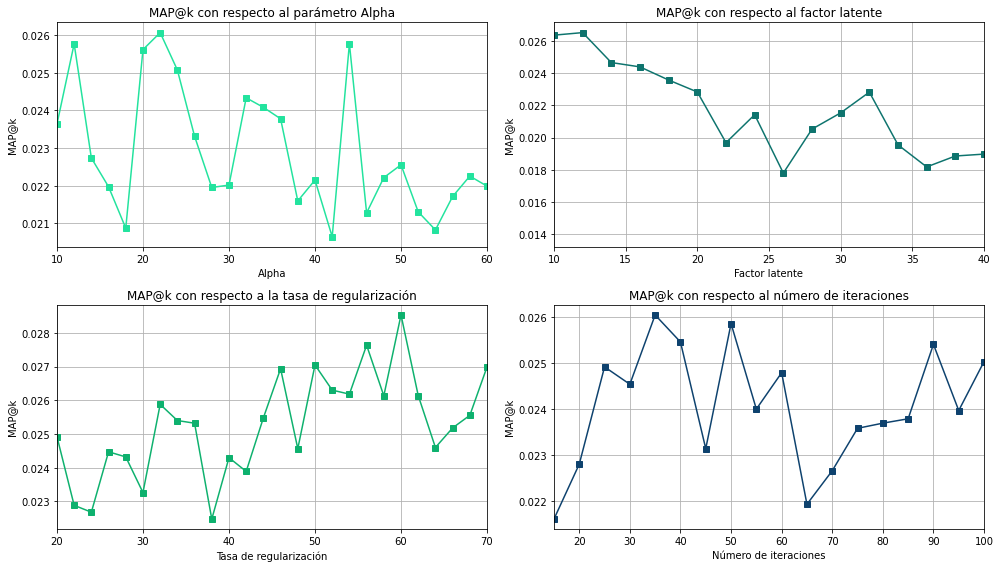

In [282]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.title('MAP@k con respecto al parámetro Alpha')
plt.plot(alphas, map_alpha, 's-c',color='#23E39E')
plt.xlabel('Alpha')
plt.ylabel('MAP@k')
plt.xlim(10,60)
plt.grid()
plt.subplot(2,2,2)
plt.title('MAP@k con respecto al factor latente')
plt.plot(factors, map_factor, 's-y',color='#0E746E')
plt.xlabel('Factor latente')
plt.ylabel('MAP@k')
plt.xlim(10,40)
plt.grid()
plt.subplot(2,2,3)
plt.title('MAP@k con respecto a la tasa de regularización')
plt.plot(regs, map_reg, 's-g',color='#0EB16E')
plt.xlabel('Tasa de regularización')
plt.ylabel('MAP@k')
plt.xlim(20,70)
plt.grid()
plt.subplot(2,2,4)
plt.title('MAP@k con respecto al número de iteraciones')
plt.plot(iterations, map_iteration, 's-m',color='#0E426E')
plt.xlabel('Número de iteraciones')
plt.ylabel('MAP@k')
plt.xlim(15,100)
plt.grid()
plt.tight_layout()
plt.show()

**Análisis:** Se evidencia como la métrica con respecto al número de iteraciones es relativamente constante entre 75 y 85, por lo cual se toman 80 iteraciones para este parámetro. En los demás parámetros no se evidencia una tendencia clara, es por eso que para elegir los hiperparámetros se realizará una validación cruzada.

* *Se realiza validación cruzada para determinar los mejores hiperparámetros de los parámetros faltantes*

In [283]:
alphas2 = [x for x in range(20,31,2)]
factors2 = [x for x in range(25,61,5)]
regs2 = [x for x in range(35,71,5)]

metrics_grid = []
alphas_grid = []
factors_grid = []
regs_grid = []

for alpha in alphas2:
    for factor in factors2:
        for reg in regs2:
            train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)
            model = AlternatingLeastSquares(factors=factor, regularization=reg, iterations=55, random_state=42)
            model.fit(train, show_progress=False)
            r = ranking_metrics_at_k(model, train.T, test.T, K=20, num_threads=0, show_progress=False)
            metrics_grid.append(r)
            alphas_grid.append(alpha)
            factors_grid.append(factor)
            regs_grid.append(reg)

In [284]:
map_grid = []

for i in range(len(metrics_grid)):
    map_grid.append(metrics_grid[i]['map'])

In [285]:
dict_metrics = {'alpha': alphas_grid, 'factor': factors_grid, 'regularization': regs_grid, 'MAP_k': map_grid}
Frame_metrics = pd.DataFrame(data=dict_metrics)

In [286]:
Frame_metrics[Frame_metrics.MAP_k == Frame_metrics.MAP_k.max()]

,alpha,factor,regularization,MAP_k
7,20,25,70,0.031383


**Análisis:** Finalmente los hiperparámetros definidos para optimizar el modelos son: alpha = 20, factor latente = 25, tasa de regularización = 70 y número de iteraciones = 80.

***Evaluación del modelo y presentación de resultados***

* *Se reentrena el modelo con los hiperparámetros seleccionados y se calcula la métrica de evaluación*

In [287]:
alpha = 20

In [288]:
train, test = train_test_split(matrix_item_user * alpha, train_percentage=0.8)

In [332]:
model = AlternatingLeastSquares(factors=25, regularization=70, iterations=80, random_state=42)
model.fit(train, show_progress=True)

  0%|          | 0/80 [00:00<?, ?it/s]

In [333]:
p_K = ranking_metrics_at_k(model, train.T, test.T, K=20, show_progress=True)
print('El modelo tiene un valor de MAP@k igual a : %0.3f' % (p_K['map']))

  0%|          | 0/5404 [00:00<?, ?it/s]

El modelo tiene un valor de MAP@k igual a : 0.030


**Análisis:** El valor de MAP@K presenta un aumento con respecto al primer modelo ejecutado, pasando de 0.021 a 0.030.

* *Se evalúa como varía la métrica respecto al valor de K, tanto para el modelo optimizado como para el caso Benchmark*

In [327]:
Ks = [5,10,20,30,50,80,100,150,200,250,300,350,400,450,500]

metrics_model = []
metrics_Benchmark = []

for K in Ks:
    r_model = ranking_metrics_at_k(model, train.T, test.T, K=K, show_progress=False)
    r_benchmark = ranking_metrics_at_k(Benchmark, train.T, test.T, K=K, show_progress=False)
    metrics_model.append(r_model)
    metrics_Benchmark.append(r_benchmark)   

In [328]:
precision_model = []
precision_benchmark = []

for i in range(len(metrics_model)):
    precision_model.append(metrics_model[i]['map'])
    precision_benchmark.append(metrics_Benchmark[i]['map'])

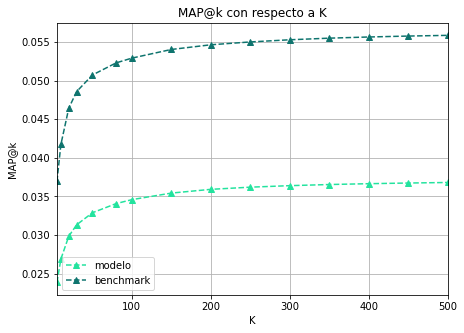

In [329]:
plt.figure(figsize=(7,5))
plt.title('MAP@k con respecto a K')
plt.plot(Ks, precision_model, '^--b', label='modelo',color='#23E39E')
plt.plot(Ks, precision_benchmark, '^--r', label='benchmark',color = '#0E746E')
plt.xlabel('K')
plt.ylabel('MAP@k')
plt.legend(loc=0)
plt.xlim(5,500)
plt.grid()
plt.show()

**Análisis:** El modelo Benchmark presenta mejores métricas que el modelo de filtro colaborativo implementado, podría asumirse que un modelo más sencillo presenta mejores resultados para el dataset. Para mejorarlo podría probarse otro modelo u otra librería, así mismo ajustar el preprocesamiento.

* *Se prueba el modelo con un usuario aleatorio*

In [358]:
user = 4352

In [359]:
usuario = np.unique(data_reviews.username[data_reviews.user_id == user])[0]
juegos_usuario_codigo = data_reviews.game_id[data_reviews.user_id == user]
juegos_usuario = list(juegos_usuario_codigo.map(dict(zip(data_games.game_id,data_games.title))).values)

In [360]:
recommended = model.recommend(userid = user, user_items = matrix_user_item, N=20, filter_items = list(juegos_usuario_codigo))

In [361]:
games = []
preds = []
for i in range(0,len(recommended)):
    game = recommended[i][0]
    pred = recommended[i][1]
    games.append(game)
    preds.append(pred)
    
recom = pd.Series(preds, index = games)
recom.index = recom.index.map(dict(zip(data_games.game_id,data_games.title)))

In [362]:
print('Usuario : ', usuario)
print('Juegos del usuario : ', juegos_usuario)

Usuario :  Turbo
Juegos del usuario :  ['NBA 2K16', 'Tom Clancy’s The Division™', 'Nether: Resurrected', 'Friday the 13th: The Game', 'Borderlands 2']


In [363]:
print('Recomendaciones por similitud: \n')
print(recom)

Recomendaciones por similitud: 

Life is Strange - Episode 1    0.835282
Paladins®                      0.627209
Unturned                       0.610484
Rust                           0.591667
XCOM: Enemy Unknown            0.579826
Max Payne 3                    0.549741
Amnesia: The Dark Descent      0.534218
Heroes &amp; Generals          0.530372
Sleeping Dogs                  0.530351
Fallout 4                      0.509052
Gang Beasts                    0.508925
Mount &amp; Blade: Warband     0.503075
HuniePop                       0.501271
Transistor                     0.477060
Saints Row: The Third          0.476850
Dirty Bomb®                    0.446205
Plague Inc: Evolved            0.424011
Verdun                         0.422305
The Walking Dead: Season 2     0.422283
Outlast                        0.393137
dtype: float64


### Parte C - Investigación

Los sistemas de recomendación más comunes son los que se generan a partir de un filtro colaborativo o los basados en contenidos. 

Para este proyecto se usó un modelo de filtro colaborativo, que presenta ventajas como la posibilidad de filtrar ítems basados en calidad y gustos, midiendo qué tan bien un ítem es afín al usuario más allá del contenido, o también la capacidad de generar recomendaciones inesperadas que pueden ser valiosas para el usuario pero que no contienen información que el usuario estaba esperando. Sin embargo, tiene inconvenientes cuando un ítem ingresa nuevo al sistema porque no tiene ninguna calificación o en su defecto tiene pocas calificaciones, o en los casos de usuarios “gray sheep” que tienen opiniones que no coinciden con el grupo por lo que no se encontrarán usuarios similares (1). 

Por su parte, el filtrado basado en contenidos no presenta estos inconvenientes, debido a que recomienda ítems basados en el perfil del usuario, analizando el contenido de los ítems que este ha calificado. Sin embargo, también puede ser poco efectivo, porque tiene la dificultad para distinguir entre información de baja y alta calidad, que pertenezcan al mismo tema (1).

Para resolver el problema que se tiene en los algoritmos anteriores, en la práctica se utilizan **Sistemas Híbridos** que usan una combinación de modelos de manera que se utilicen las fortalezas de cada uno de estos. Por el tipo de combinación que se aplique, los sistemas híbridos se dividen así (2):

-	Ponderado: El resultado de los distintos algoritmos de recomendación son combinados con diferentes pesos para producir una sola recomendación.
-	Intercambio: El sistema aplica un algoritmo de recomendación de acuerdo con diferentes criterios de los datos o resultados.
-	Mixto: Se presenta resultados de diferentes sistemas de recomendación al mismo tiempo.
-	Combinación de características: Características de distintas fuentes de datos se utilizan en un solo algoritmo de recomendación.
-	En cascada: Un algoritmo de recomendación mejora los resultados de otro
-	Aumento de funciones: Los resultados de un algoritmo sirven como entrada para otro algoritmo.


**Implementación en el dataset**

En este dataset se puede usar un **Sistema en Cascada**, generando inicialmente un modelo de filtro colaborativo y luego un modelo basado en contenidos.

Para el modelo basado en contenidos se tomaría la variable *‘genres’*, la cual actualmente tiene la estructura *[Adventure, Animation, Children, Comedy, Fantasy]*. Para procesar esta variable, se debe realizar un encoding generando una columna para cada género y asignándole valores binarios (1,0). 

Luego de tener la variable en esta estructura, se pondera cada género y luego se reescalan los resultados, para obtener los pesos de preferencia de cada usuario. 

Finalmente se corre el modelo basado en contenidos, que acotaría los resultados del filtro colaborativo y mejoraría las recomendaciones para los usuarios. Se podrían probar las diferencias generando las recomendaciones para uno o varios usuarios aleatorios solo con el filtro colaborativo y luego de implementar el modelo basado en contenidos.


***Referencias***

(1) https://repository.unab.edu.co/bitstream/handle/20.500.12749/3331/2003_Tesis_Olga_Lucia_Monroy_Vecino.pdf?sequence=1&isAllowed=y

(2) http://oa.upm.es/43313/1/TFM_MIGUEL_MOLINA_CRESPO.pdf